## Extended Labeled Faces In The Wild (ELFW): Augmenting Classes For Face Segmentation

In [2]:
import os
import random
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

# 1. Data preprocessing 

In [2]:
# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, root, labels_file, transform=None):
        self.root = root
        self.labels_file = labels_file
        self.transform = transform
        self.data = self.load_data()

    def load_data(self):
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()
        data = []
        for line in lines:
            img_name, label = line.strip().split(': ')
            data.append((img_name, int(label) - 1))  # Subtract 1 to ensure labels start from 0
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the path to your dataset and labels file
path = 'Annotated Data'
labels_file = 'labels.txt'

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Load dataset using CustomDataset
dataset = CustomDataset(root=path, labels_file=labels_file, transform=transform)

# Partition data into training, testing, and validation sets
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

# Data loaders for training, testing, and validation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


#  2. Load parameters of a pretrained model

In [3]:
# Load Parameters of a Pretrained Model
pretrained_model = models.resnet18(pretrained=True)

num_classes = 3  # # 'hair': 1, 'spects': 2, 'cap': 3
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# 3.Finetune the network 

In [4]:
# Fine-tune the Network
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)  

num_epochs = 10  
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = pretrained_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

Epoch 1, Training Loss: 0.7358589612919352, Validation Loss: 1.200751523176829
Epoch 2, Training Loss: 0.7557905944793121, Validation Loss: 1.2029800415039062
Epoch 3, Training Loss: 0.7787942526781041, Validation Loss: 0.6618116199970245
Epoch 4, Training Loss: 0.5208843117174895, Validation Loss: 0.9829634229342142
Epoch 5, Training Loss: 0.5513003471752872, Validation Loss: 0.4791804651419322
Epoch 6, Training Loss: 0.41552212178383185, Validation Loss: 0.40933921933174133
Epoch 7, Training Loss: 0.44157397747039795, Validation Loss: 0.5446835458278656
Epoch 8, Training Loss: 0.38182748951341794, Validation Loss: 0.4879973928133647
Epoch 9, Training Loss: 0.4023408889770508, Validation Loss: 0.564191460609436
Epoch 10, Training Loss: 0.3713769915959109, Validation Loss: 0.6271151701609293


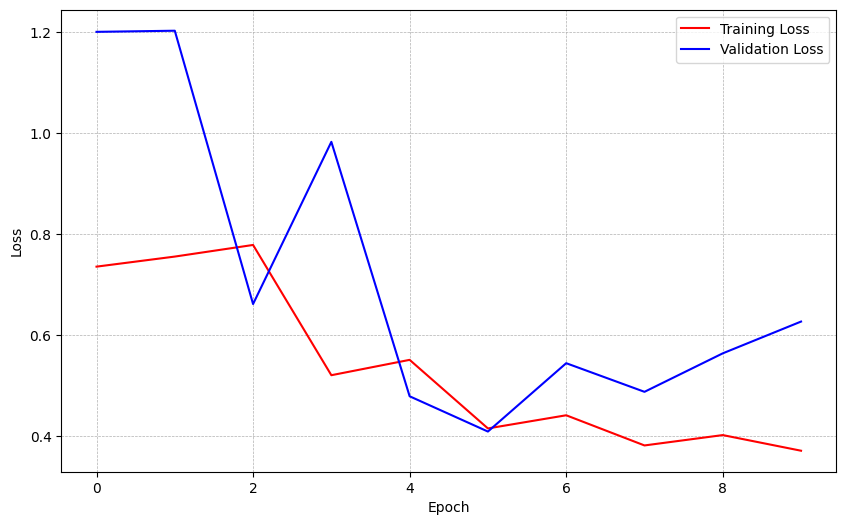

In [5]:
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Plotting Training Loss with red color and grid lines
plt.plot(train_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Plotting Validation Loss with blue color and grid lines
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()


# 4.Evaluate on the test dataset.

In [6]:
# Evaluate on the test dataset
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = correct / total
print(f"Accuracy on Test Dataset: {accuracy}")
accuracy_percentage = accuracy * 100
print(f"Accuracy on Test Dataset: {accuracy_percentage:.4f}%")

Accuracy on Test Dataset: 0.8181818181818182
Accuracy on Test Dataset: 81.8182%


# 5. Classification report

In [10]:

# Classification Report
class_names = ['hair', 'spects', 'cap']  # Define class names based on your dataset
labels = [0, 1, 2]  # Define corresponding numeric labels
print(classification_report(true_labels, predicted_labels, labels=labels, target_names=class_names))


              precision    recall  f1-score   support

        hair       1.00      0.76      0.87        17
      spects       0.57      1.00      0.73         4
         cap       0.50      1.00      0.67         1

    accuracy                           0.82        22
   macro avg       0.69      0.92      0.75        22
weighted avg       0.90      0.82      0.83        22



In [13]:
# Save the trained model
save_path = os.path.join('pretrained_model.pth')
torch.save(pretrained_model.state_dict(), save_path)
print(f"Model saved at: {save_path}")

Model saved at: pretrained_model.pth


# 6. Deployment

In [4]:
import os
from PIL import Image, ImageDraw
import numpy as np
import cv2
import gradio as gr

def create_face_mask(image):
    # Convert image to grayscale for face detection
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    
    # Load pre-trained face detector (Haar Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    
    for (x, y, w, h) in faces:
        face_polygon = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
        draw.polygon(face_polygon, fill=500)  # Fill with white color
    
    mask = Image.eval(mask, lambda x: 300 if x > 0 else 0)  
    
    return mask

# Function to process images and generate masks
def process_image(input_image):
    # Open the uploaded image
    image = Image.fromarray(input_image.astype('uint8'), 'RGB')
    
    # Create segmentation mask
    mask = create_face_mask(image)
    
    masked_image = Image.new("RGB", image.size, (0, 0, 0))  # Create black background image
    masked_image.paste(image, (0, 0), mask=mask)  # Paste original image with masked face regions
    
    # Convert the masked image back to numpy array
    masked_image_array = np.array(masked_image)
    
    return masked_image_array

# Gradio interface
iface = gr.Interface(fn=process_image, inputs="image", outputs="image", title="Extended Labeled Faces ",
                     description="Upload an image to generate a mask with black background and blue face regions.")
iface.launch()


Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


In [4]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import gradio as gr

# Load the pretrained ResNet-18 model
pretrained_model = models.resnet18(pretrained=True)

# Define the image processing function to generate a hair mask
def process_image(input_image):
    # Convert the Gradio Image object to a NumPy array
    image = input_image.astype(np.uint8)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Use a threshold to create a binary mask for the hair
    _, hair_mask = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Invert the mask (black for hair, white for background)
    hair_mask = cv2.bitwise_not(hair_mask)

    # Convert the hair mask to RGB format for display
    hair_mask_rgb = cv2.cvtColor(hair_mask, cv2.COLOR_GRAY2RGB)
    
    # Convert the hair mask back to Gradio Image format
    hair_mask_image = gr.Image(hair_mask_rgb.astype(np.uint8))
    
    return hair_mask_image

# Gradio interface for generating a hair mask
iface_hair_mask = gr.Interface(fn=process_image, inputs="image", outputs="image", 
                               title="Mask Generator", description="Upload an image to generate a hair mask.")
iface_hair_mask.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Update 3

# 1) Dataset processing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, root, labels_file, transform=None):
        self.root = root
        self.labels_file = labels_file
        self.transform = transform
        self.data = self.load_data()

    def load_data(self):
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()
        data = []
        for line in lines:
            img_name, label = line.strip().split(': ')
            data.append((img_name, int(label) - 1))  # Subtract 1 to ensure labels start from 0
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Define the path to your dataset and labels file
path = 'Annotated Data'
labels_file = 'labels.txt'

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load dataset using CustomDataset and apply transforms
train_dataset = CustomDataset(root=path, labels_file=labels_file, transform=train_transform)
test_dataset = CustomDataset(root=path, labels_file=labels_file, transform=test_transform)

# Calculate mean and standard deviation of training data for normalization
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
data_mean = torch.zeros(3)
data_std = torch.zeros(3)

for images, _ in train_loader:
    data_mean += torch.mean(images, dim=(0, 2, 3))
    data_std += torch.std(images, dim=(0, 2, 3))

data_mean /= len(train_dataset)
data_std /= len(train_dataset)

print("Mean:", data_mean)
print("Standard Deviation:", data_std)

# Data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Mean: tensor([0.0003, 0.0003, 0.0003])
Standard Deviation: tensor([0.0010, 0.0010, 0.0010])


# 2) Mini version of the network in transfer learning

In [15]:
# Define the mini network for transfer learning
class MiniNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MiniNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the mini network with appropriate initialization and biases
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

In [13]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define the mini network for transfer learning
class MiniNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MiniNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Adjust the input size for the linear layer based on the output size of the last conv layer
        self.classifier = nn.Linear(32 * 16 * 16, num_classes)  # Assuming input images are 64x64 pixels with 3 channels (RGB)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the mini network with appropriate initialization and biases
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

# Create an instance of the MiniNetwork
model = MiniNetwork(num_classes=3)  # Adjust num_classes as needed

# Initialize the weights of the model
model.apply(weights_init)

# Print the model summary
summary(model, input_size=(3, 64, 64))  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Linear-7                    [-1, 3]          24,579
Total params: 29,667
Trainable params: 29,667
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.69
Params size (MB): 0.11
Estimated Total Size (MB): 1.85
----------------------------------------------------------------


#  Training

# (i) Train for just one or two samples, Show that you can overfit with 100% accuracy.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Train for just one or two samples to demonstrate overfitting
overfit_train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

overfit_mini_net = MiniNetwork(num_classes=len(set(label for _, label in train_dataset.data)))
overfit_mini_net.apply(weights_init)

optimizer = optim.SGD(overfit_mini_net.parameters(), lr=best_config["lr"], momentum=best_config["momentum"], weight_decay=best_config["weight_decay"])

overfit_train_losses = []

# Train for a few epochs to demonstrate overfitting
for epoch in range(10):  # Train for 10 epochs (adjust as needed)
    overfit_mini_net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(overfit_train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = overfit_mini_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(overfit_train_loader)
    overfit_train_losses.append(train_loss)

# Print final training loss for the overfitting demonstration
print("Overfitting Demonstration - Final Training Loss:", overfit_train_losses[-1])

# Calculate and print accuracy on a single sample to demonstrate overfitting
inputs, labels = next(iter(overfit_train_loader))
outputs = overfit_mini_net(inputs)
_, predicted = torch.max(outputs, 1)
accuracy = (predicted == labels).sum().item() / labels.size(0) * 100
print("Overfitting Demonstration - Accuracy on Single Sample:", accuracy)


Overfitting Demonstration - Final Training Loss: 0.5178271473789784
Overfitting Demonstration - Accuracy on Single Sample: 100.0


# (ii) Do hyperparameter tuning for learning rate, momentum, and weight decay

In [5]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()

# Hyperparameter tuning
best_val_loss = float('inf')
best_config = None
best_model_params = None  # Initialize variable to store best model parameters

for lr in [1e-4, 5e-4, 1e-3]:
    for momentum in [0.9, 0.95]:
        for weight_decay in [1e-5, 5e-5, 1e-4]:
            mini_net = MiniNetwork(num_classes=len(set(label for _, label in train_dataset.data)))
            mini_net.apply(weights_init)

            optimizer = optim.SGD(mini_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

            train_losses = []
            val_losses = []

            for epoch in range(10):  # Train for 10 epochs
                mini_net.train()
                running_loss = 0.0
                for i, data in enumerate(train_loader, 0):
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = mini_net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                train_loss = running_loss / len(train_loader)
                train_losses.append(train_loss)

                mini_net.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for data in test_loader:  # Use test_loader for validation
                        inputs, labels = data
                        outputs = mini_net(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                    val_loss = val_loss / len(test_loader)
                    val_losses.append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = {"lr": lr, "momentum": momentum, "weight_decay": weight_decay}
                    best_model_params = mini_net.state_dict()  # Save best model parameters

            # Print final losses and hyperparameters for each model
            print(f"LR={lr}, Momentum={momentum}, Weight Decay={weight_decay}")
            print(f"Final Training Loss: {train_losses[-1]}, Final Validation Loss: {val_losses[-1]}\n")


LR=0.0001, Momentum=0.9, Weight Decay=1e-05
Final Training Loss: 0.6155093497243421, Final Validation Loss: 0.6005219930204851

LR=0.0001, Momentum=0.9, Weight Decay=5e-05
Final Training Loss: 0.5711175167355044, Final Validation Loss: 0.5186565199802662

LR=0.0001, Momentum=0.9, Weight Decay=0.0001
Final Training Loss: 0.5335073614942616, Final Validation Loss: 0.49422821197016487

LR=0.0001, Momentum=0.95, Weight Decay=1e-05
Final Training Loss: 0.5305896427096992, Final Validation Loss: 0.5194831979942733

LR=0.0001, Momentum=0.95, Weight Decay=5e-05
Final Training Loss: 0.5358120855586282, Final Validation Loss: 0.5639722051805464

LR=0.0001, Momentum=0.95, Weight Decay=0.0001
Final Training Loss: 0.5810817862892973, Final Validation Loss: 0.4641231552794062

LR=0.0005, Momentum=0.9, Weight Decay=1e-05
Final Training Loss: 0.4729376394173195, Final Validation Loss: 0.4554801945542467

LR=0.0005, Momentum=0.9, Weight Decay=5e-05
Final Training Loss: 0.47816539144721526, Final Valida

In [6]:
# Print best model parameters
print("\nBest Model Parameters:")
print("Learning Rate:", best_config["lr"])
print("Momentum:", best_config["momentum"])
print("Weight Decay:", best_config["weight_decay"])
print("Final Training Loss:", train_losses[-1])
print("Final Validation Loss:", val_losses[-1])


Best Model Parameters:
Learning Rate: 0.001
Momentum: 0.9
Weight Decay: 0.0001
Final Training Loss: 0.7655121423304081
Final Validation Loss: 0.7384250849999231


# iii) Plot validation and training loss. 

In [7]:
# Train the best model with the selected hyperparameters
best_mini_net = MiniNetwork(num_classes=len(set(label for _, label in train_dataset.data)))
best_mini_net.load_state_dict(best_model_params)  # Load best model parameters
best_optimizer = optim.SGD(best_mini_net.parameters(), lr=best_config["lr"], momentum=best_config["momentum"], weight_decay=best_config["weight_decay"])

train_losses = []
val_losses = []

for epoch in range(50):  # Train for 50 epochs
    best_mini_net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()
        outputs = best_mini_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    best_mini_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = best_mini_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")


Epoch 1, Training Loss: 0.46649976074695587, Validation Loss: 0.4145577885210514
Epoch 2, Training Loss: 0.46300835856075945, Validation Loss: 0.3985827788710594
Epoch 3, Training Loss: 0.48011305208863886, Validation Loss: 0.43017911037494394
Epoch 4, Training Loss: 0.455614801367809, Validation Loss: 0.3958558539121315
Epoch 5, Training Loss: 0.484267913061997, Validation Loss: 0.39613729574043177
Epoch 6, Training Loss: 0.43636964492756747, Validation Loss: 0.42161660461590206
Epoch 7, Training Loss: 0.4572535280523629, Validation Loss: 0.39394361423007374
Epoch 8, Training Loss: 0.4389948647083907, Validation Loss: 0.41358971165428904
Epoch 9, Training Loss: 0.4758280752034023, Validation Loss: 0.39697993463226433
Epoch 10, Training Loss: 0.4716500365014734, Validation Loss: 0.4006899082069767
Epoch 11, Training Loss: 0.43932798350679464, Validation Loss: 0.36359706710510215
Epoch 12, Training Loss: 0.46240057231023396, Validation Loss: 0.3951292932033539
Epoch 13, Training Loss: 0

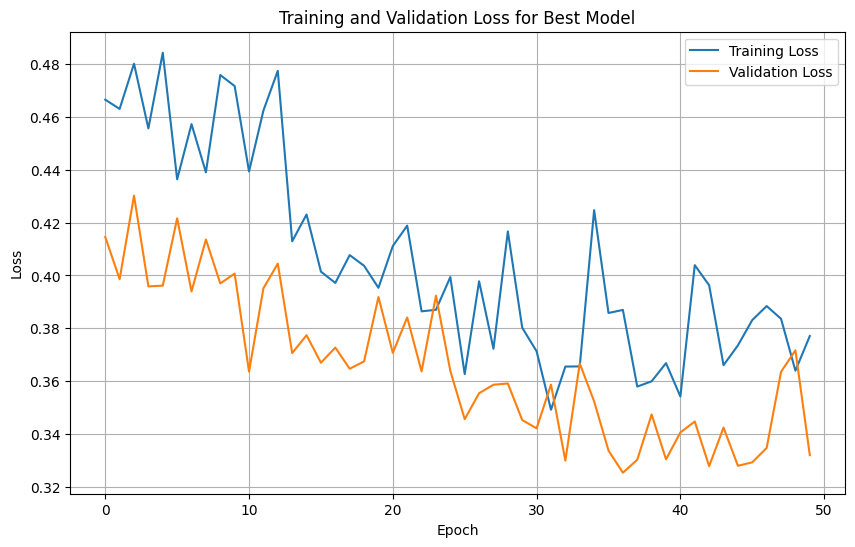

In [10]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(10, 6))

# Plot training and validation losses with gridlines
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for Best Model")
plt.grid(True)  # Add gridlines
plt.show()


# iv. Evaluate and report performance on test data.

In [9]:
# Evaluate performance on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(best_mini_net, test_loader)
print("Test Accuracy:", test_accuracy)



Test Accuracy: 0.8464912280701754


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
from PIL import Image

# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, root, labels_file, transform=None):
        self.root = root
        self.labels_file = labels_file
        self.transform = transform
        self.data = self.load_data()

    def load_data(self):
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()
        data = []
        for line in lines:
            img_name, label = line.strip().split(': ')
            data.append((img_name, int(label) - 1))  # Subtract 1 to ensure labels start from 0
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the path to your dataset and labels file
path = 'Annotated Data'
labels_file = 'labels.txt'

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load dataset using CustomDataset and apply transforms
train_dataset = CustomDataset(root=path, labels_file=labels_file, transform=train_transform)
test_dataset = CustomDataset(root=path, labels_file=labels_file, transform=test_transform)

# Calculate mean and standard deviation of training data for normalization
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
data_mean = torch.zeros(3)
data_std = torch.zeros(3)

for images, _ in train_loader:
    data_mean += torch.mean(images, dim=(0, 2, 3))
    data_std += torch.std(images, dim=(0, 2, 3))

data_mean /= len(train_dataset)
data_std /= len(train_dataset)

print("Mean:", data_mean)
print("Standard Deviation:", data_std)

# Data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define the mini network for transfer learning
class MiniNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MiniNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the mini network with appropriate initialization and biases
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()

# Hyperparameter tuning
best_val_loss = float('inf')
best_config = None
best_model_params = None  # Initialize variable to store best model parameters

for lr in [1e-4, 5e-4, 1e-3]:
    for momentum in [0.9, 0.95]:
        for weight_decay in [1e-5, 5e-5, 1e-4]:
            mini_net = MiniNetwork(num_classes=len(set(label for _, label in train_dataset.data)))
            mini_net.apply(weights_init)

            optimizer = optim.SGD(mini_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

            train_losses = []
            val_losses = []

            for epoch in range(10):  # Train for 10 epochs
                mini_net.train()
                running_loss = 0.0
                for i, data in enumerate(train_loader, 0):
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = mini_net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                train_loss = running_loss / len(train_loader)
                train_losses.append(train_loss)

                mini_net.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for data in test_loader:  # Use test_loader for validation
                        inputs, labels = data
                        outputs = mini_net(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                    val_loss = val_loss / len(test_loader)
                    val_losses.append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = {"lr": lr, "momentum": momentum, "weight_decay": weight_decay}
                    best_model_params = mini_net.state_dict()  # Save best model parameters

            # Print final losses and hyperparameters for each model
            print(f"LR={lr}, Momentum={momentum}, Weight Decay={weight_decay}")
            print(f"Final Training Loss: {train_losses[-1]}, Final Validation Loss: {val_losses[-1]}\n")

# Print best model parameters
print("\nBest Model Parameters:")
print("Learning Rate:", best_config["lr"])
print("Momentum:", best_config["momentum"])
print("Weight Decay:", best_config["weight_decay"])
print("Final Training Loss:", train_losses[-1])
print("Final Validation Loss:", val_losses[-1])

# Train the best model with the selected hyperparameters
best_mini_net = MiniNetwork(num_classes=len(set(label for _, label in train_dataset.data)))
best_mini_net.load_state_dict(best_model_params)  # Load best model parameters
best_optimizer = optim.SGD(best_mini_net.parameters(), lr=best_config["lr"], momentum=best_config["momentum"], weight_decay=best_config["weight_decay"])

train_losses = []
val_losses = []

for epoch in range(50):  # Train for 50 epochs
    best_mini_net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()
        outputs = best_mini_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    best_mini_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = best_mini_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

# Evaluate performance on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(best_mini_net, test_loader)
print("Test Accuracy:", test_accuracy)


Mean: tensor([0.0003, 0.0003, 0.0003])
Standard Deviation: tensor([0.0010, 0.0010, 0.0010])
LR=0.0001, Momentum=0.9, Weight Decay=1e-05
Final Training Loss: 0.5279821244807079, Final Validation Loss: 0.5232192786603138

LR=0.0001, Momentum=0.9, Weight Decay=5e-05
Final Training Loss: 0.5481630697332579, Final Validation Loss: 0.5566230919854395

LR=0.0001, Momentum=0.9, Weight Decay=0.0001
Final Training Loss: 0.4704068272278227, Final Validation Loss: 0.4978614220845288

LR=0.0001, Momentum=0.95, Weight Decay=1e-05
Final Training Loss: 0.580445401627442, Final Validation Loss: 0.5491241306580347

LR=0.0001, Momentum=0.95, Weight Decay=5e-05
Final Training Loss: 0.5403250281153054, Final Validation Loss: 0.5096603562605793

LR=0.0001, Momentum=0.95, Weight Decay=0.0001
Final Training Loss: 0.4968969883589909, Final Validation Loss: 0.4568138261293543

LR=0.0005, Momentum=0.9, Weight Decay=1e-05
Final Training Loss: 0.4919222202794305, Final Validation Loss: 0.5073761474983446

LR=0.000